# Install Libraries

In [ ]:
pip install tensorflow==2.4.1

In [ ]:
pip install keras==2.4.3

In [ ]:
pip install pythainlp

In [ ]:
pip install opencv-python

In [ ]:
pip install gensim

In [ ]:
pip install pandas

In [ ]:
pip install numpy

In [ ]:
pip install matplotlib

In [ ]:
pip install sklearn

In [ ]:
pip install python-Levenshtein

# Import Libraries

In [1]:
# Plot Graph
import matplotlib.pyplot as plt

# Sklearn Report
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 

# Load Vectors
from gensim.models import KeyedVectors

# Utility
import numpy as np
import os, random, math
import re
import time
from pythainlp.tokenize import word_tokenize
from pythainlp.tag import pos_tag
from pythainlp.corpus import download, get_corpus_path
import shutil
import cv2


# Model Utility
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import string

# Keras Model
import tensorflow as tf
import tensorflow.keras
import keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, GRU, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Conv2D
from tensorflow.keras.layers import Bidirectional, concatenate, SpatialDropout1D, MaxPooling1D, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.layers import Dot, Reshape, TimeDistributed, BatchNormalization, Flatten, Activation
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.engine.topology import Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
download('thai2fit_wv')
W_MODEL_PATH = get_corpus_path('thai2fit_wv')
print('')
print(W_MODEL_PATH)

thai2fit_model = KeyedVectors.load_word2vec_format(W_MODEL_PATH,binary=True)
thai2fit_weight = thai2fit_model.vectors

thai2dict = {}   
for word in thai2fit_model.index_to_key:
    thai2dict[word] = thai2fit_model[word]

all_thai2dict = sorted(set(thai2dict))
thai2dict_to_ix = dict((c, i) for i, c in enumerate(thai2dict)) #convert thai2fit to index 
ix_to_thai2dict = dict((v,k) for k,v in thai2dict_to_ix.items())  #convert index to thai2fit
n_thai2dict = len(thai2dict_to_ix)

print('word count: ', n_thai2dict)

Corpus: thai2fit_wv
- Already up to date.

/Users/panja/pythainlp-data/thai2vec.bin
word count:  51358


In [3]:
def clean_data_sen(sentence):
    sentence = sentence.lower()
    #Clean all links, hashtags, tags, phone numbers
    sentence = re.sub(r"[@#]\S+|02\d{7}|0[689]\d{8}|http\S+|www\S+|m\.me\S+|\n","",sentence)
    sentence = re.sub(r"เเ",r"แ",sentence)
    #Clean all special characters
    sentence  = "".join([char for char in sentence if char not in string.punctuation])
    return sentence

def prepare_sequence_word(input_text):
    idxs = list()
    for word in input_text:
        if word in thai2dict:
            idxs.append(thai2dict_to_ix[word])
        else:
            idxs.append(thai2dict_to_ix["unknown"])
    return idxs

def clean_token(data):
    clean = [clean_data_sen(x) for x in data]
    token = [word_tokenize(x, engine="newmm", keep_whitespace=False) for x in clean]
    return token

def embed(data):
    embed = [prepare_sequence_word(x) for x in data]
    word = pad_sequences(maxlen=maxlen, sequences=embed, 
                        value=thai2dict_to_ix["pad"], 
                        padding='post', truncating='post')
    return word

def image_load(data, datapath):
    x_image = []
    for fname in data.index:
        path = '/Users/panja/Desktop/promotion_classifier_data/' + datapath +'/'
        fpath = os.path.join(path, fname)
        fpath = fpath + '.jpg'
        im = cv2.imread(fpath)
        im_resized = cv2.resize(im, (224,224), interpolation = cv2.INTER_LINEAR)
        im_norm = cv2.normalize(im_resized, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        x_image.append(im_norm)
    return x_image

def plot_graphs(hist, string):
    plt.plot(hist.history[string])
    plt.plot(hist.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
def report(y, y_pred):
    print('')
    print('Accuracy Score:',accuracy_score(y, y_pred))
    print('______________________________________________________')
    print('')
    print('Confusion Matrix:')
    print('')
    print(confusion_matrix(y, y_pred))
    print('______________________________________________________')
    print('')
    print('Classification Report: ')
    print('')
    print(classification_report(y, y_pred))

# Import Datasets and Preprocesses

In [4]:
train_df = pd.read_csv('training_set.csv',encoding='UTF-8',header=0,names=['id','pro','spam'])
test_df = pd.read_csv('testing_set.csv',encoding='UTF-8',header=0,names=['id','pro'])

In [5]:
forconcat = pd.read_csv('testing_set.csv',encoding='UTF-8')

In [6]:
train_df.sample(100)

,id,pro,spam
55,1NWLAvNz8rJHM6tPPbHmKr9WujZT7e,เปิดตัวเมนูใหม่ล่าสุดด~ “นมหนึบภูเขาไฟ”🍼🌋 \n\n\n\nราคาเพียง 69 บาท ซื้อสองแก้ว 120 บาท❗️\n\n\n\nมีให้เลือก 4 รสชาติ นมสด นมชมพู ชาเขียว\n\n\n\nชาไทย,0
858,1NWLBy6Comddjljzfw3Cj3LBlGJkQS,ฟรีจากวันนี้ ถึง10 กันยายน61 เมื่อสั่งอาหาร 1 อย่างฟรี 1 อย่างจับคู่กับอะไรก็ได้ \n\n\nเพียงแค่บอกตามร้านจากวงใน เฉพาะทานที่ร้าน 1 ครั้งต่อ1ท่านเท่านั้น\n\n\n,0
1748,1NWLCXQRdJRL9QOMEVPyLOZZx6vdXN,สุดยอดผัดไทย ผัดไทยดอกคำใต้ 40 บาท อิ่มทุกจาน,1
1438,1NWLCwhVMu3zA7YqBYWubniT0ksDjF,Promotion Peach and Tea,0
2053,1NWLDD8b7sgBkB6U0IVN8xfJk0SRU5,เปิดรับจองด่วน!!!!! สำหรับรอบรับประทานวันที่ 28-30 ก.ย.นี้ ปูAtlantic Brown Crab ตัวละ850.-&Canadian Lobster ตัวละ650.- ช้าหมดอดอร่อย!!! ติดต่อ085-312-1234,1
1264,1NWLDAUpp18JmdfmWXs6nHiRODYF1C,NaN,0
1058,1NWLCQowt47B31XtCZKupxvOmXOoKq,ซุปเห็ดแสนแซบ\n\n\n,1
306,1NWLCZAmIzZvtE5GChI0uaI4A3dM5S,ยำไข่เยี้ยวม้า,1
1388,1NWLBInTdAZFyHDx43toTKc6hA2J3m,พายหมูแดง อบสดใหม่ทุกวัน มาลิ้มลองความอร่อยได้ที่ \n\n\n\n โฮ เหม่งจ๋าย\n\n\n\nโปรติ๋มซำ 🥢\n\n\n\nจันทร์ -ศุกร์ ลด 50%\n\n\n\nเสาร์ - อาทิตย์ ลด 30%\n\n\n\n***วันหยุดนักขัตฤกษ์ ราคาเต็ม\n\n\n\n11.00 - 14.30\n\n\n\nสอบถาม หรือ สำรองโต้ะ \n\n\n\nได้ที่ ☎️ 02-9347723,0
1040,1NWLCm8Q7nqTmZQJ3kdknVwQlNvPaj,"อร่อยน้ำเข้มข้นได้เยอะมาก""ล้ำลำจนลืมอิ่ม"" สมกับคำล่ำลือว่า ""ร้านสะอาด ล้ำลำแต้ๆเจ้า"" ไม่ต้องไปถึงเชียงราย",1


In [7]:
print('Train NaN:',train_df['pro'].isna().sum())
print('Test NaN:',test_df['pro'].isna().sum())

Train NaN: 570
Test NaN: 159


In [8]:
train_df.index = train_df['id']
test_df.index = test_df['id']

In [9]:
train_df.fillna(' ',inplace=True)
test_df.fillna(' ',inplace=True)

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df['pro'], train_df['spam'], test_size=0.10, random_state=42)

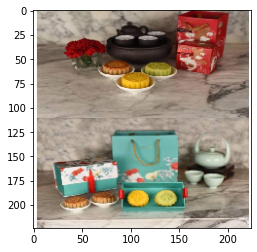

In [11]:
im = cv2.imread('/Users/panja/Desktop/promotion_classifier_data/training_images/1NWL9mqJ9EuoEeuumxRY5osW1rhkSd.jpg')
im_resized = cv2.resize(im, (224, 224), interpolation = cv2.INTER_LINEAR)
im_norm = cv2.normalize(im_resized, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.imshow(cv2.cvtColor(im_resized, cv2.INTER_AREA))
plt.show()

In [12]:
x_image_train = image_load(x_train, 'training_images')
x_image_test = image_load(test_df, 'testing_images')
x_image_valid = image_load(x_valid, 'training_images')

In [13]:
x_image_train = np.array(x_image_train).reshape(len(x_image_train),224,224,3)
x_image_test = np.array(x_image_test).reshape(len(x_image_test),224,224,3)
x_image_valid = np.array(x_image_valid).reshape(len(x_image_valid),224,224,3)

In [14]:
token_tra = clean_token(x_train)
token_test = clean_token(test_df['pro'])
token_valid = clean_token(x_valid)


print('longest train: ',len(max(token_tra, key=len)))
print('longest test: ',len(max(token_test, key=len)))
print('longest valid: ',len(max(token_valid, key=len)))

longest train:  225
longest test:  292
longest valid:  215


In [15]:
maxlen=300
word_tra = embed(token_tra)
word_test = embed(token_test)
word_valid = embed(token_valid)

word_tra = np.expand_dims(word_tra, -1)
word_test = np.expand_dims(word_test, -1)
word_valid = np.expand_dims(word_valid, -1)

# Deep Learning Model

In [21]:
from keras.applications import VGG16

image_input = Input(shape=(224, 224, 3), name='image')
vgg = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))(image_input)
vgg_outs = Flatten()(vgg)
dense_vgg = Dense(256, activation='relu')(vgg_outs)


word_input = Input(shape=(300,), dtype='int32', name='text')
word_embedded = Embedding(input_dim=n_thai2dict,
                            output_dim=300,
                            weights = [thai2fit_weight],
                            mask_zero=False,
                            name='word_embedding', trainable=False)(word_input)
lstm_outs1 = tensorflow.keras.layers.Bidirectional(LSTM(256, return_sequences=True))(word_embedded)
lstm_outs2 = tensorflow.keras.layers.Bidirectional(LSTM(256, return_sequences=False))(lstm_outs1)


im_text = concatenate([dense_vgg, lstm_outs2])
dropout = Dropout(0.3)(im_text)
output = Dense(1, activation='sigmoid')(dropout)

model = Model([image_input, word_input], outputs=output)
model.compile(optimizer = Adam(lr=0.00001), 
              loss = 'binary_crossentropy', metrics = ['acc'])

model.layers[2].trainable = False
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 300)]        0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    image[0][0]                      
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 300, 300)     15407400    text[0][0]                       
____________________________________________________________________________________________

In [22]:
filepath="spam_best.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')
hist = model.fit([x_image_train, word_tra], y_train, 
                 validation_data=([x_image_valid, word_valid], y_valid), 
                 epochs=15, batch_size=64, callbacks = [checkpoint])

Epoch 1/15
30/30 [==============================] - 475s 16s/step - loss: 0.6905 - acc: 0.5350 - val_loss: 0.6204 - val_acc: 0.6682

Epoch 00001: val_acc improved from -inf to 0.66825, saving model to spam_best.01-0.6682.hdf5
Epoch 2/15
30/30 [==============================] - 472s 16s/step - loss: 0.5558 - acc: 0.7304 - val_loss: 0.5741 - val_acc: 0.7156

Epoch 00002: val_acc improved from 0.66825 to 0.71564, saving model to spam_best.02-0.7156.hdf5
Epoch 3/15
30/30 [==============================] - 472s 16s/step - loss: 0.4784 - acc: 0.7733 - val_loss: 0.5528 - val_acc: 0.7299

Epoch 00003: val_acc improved from 0.71564 to 0.72986, saving model to spam_best.03-0.7299.hdf5
Epoch 4/15
30/30 [==============================] - 472s 16s/step - loss: 0.3462 - acc: 0.8728 - val_loss: 0.5624 - val_acc: 0.7488

Epoch 00004: val_acc improved from 0.72986 to 0.74882, saving model to spam_best.04-0.7488.hdf5
Epoch 5/15
30/30 [==============================] - 474s 16s/step - loss: 0.2573 - acc:

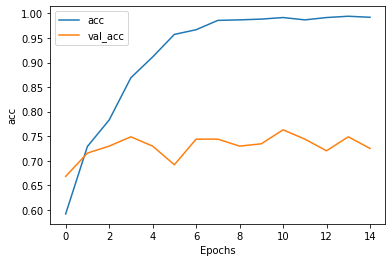

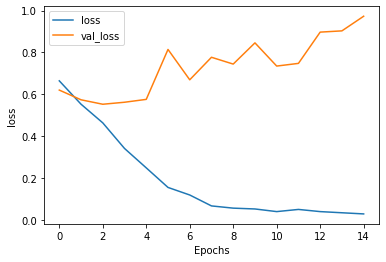

In [23]:
plot_graphs(hist, 'acc')
plot_graphs(hist, 'loss')

# Prediction

I used early-stopping technique to avoid overfitting.

In [24]:
loaded_model = load_model('/Users/panja/Desktop/promotion_classifier_data/spam_best.06-0.8294.hdf5')

y_pred_valid = loaded_model.predict([x_image_valid,word_valid])
y_pred_valid_de = np.round(y_pred_valid,0)
report(y_valid, y_pred_valid_de)


Accuracy Score: 0.8293838862559242
______________________________________________________

Confusion Matrix:

[[92 15]
 [21 83]]
______________________________________________________

Classification Report: 

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       107
           1       0.85      0.80      0.82       104

    accuracy                           0.83       211
   macro avg       0.83      0.83      0.83       211
weighted avg       0.83      0.83      0.83       211



In [25]:
prediction = loaded_model.predict([x_image_test,word_test])
prediction = np.round(prediction,0)
prediction = pd.DataFrame(prediction, columns=['prediction'])
prediction['id'] = test_df.index
prediction = pd.merge(forconcat, prediction, left_on='PromotionId', right_on='id').drop(columns=['id'])

In [26]:
prediction.sample(10)

,PromotionId,description,prediction
350,1NWL9vs7A42QKLqYyNHeUSgcl8XXsQ,Surprised! Sizzler ใจดีต่อระยะเวลา Promotion Salad Bar 139 บาท พิเศษเพื่อลูกค้า Sizzler โดยเฉพาะ \n\n\nกับหลากหลายเมนูอาหาร ไม่ว่าจะเป็น ซุป สลัด พาสต้า ของหวาน ผลไม้ ให้คุณๆได้เลือกทานอย่างไม่อั้น \n\n\n\n\n\nผักสลัดสดสะอาด อาหารถูกใจได้ที่ Sizzler ทุกสาขา,0.0
63,1NWLCkGQyaE4hXymdRByk6tJ7mqxwE,NaN,1.0
457,1NWLDJUA2u9ZFtoCf9MU363KXnlnon,NaN,0.0
102,1NWLB0uFDW1yfZbRMWvupoM6VFJc5p,เบียร์3ฟรี1\n\n\n3แก้วฟรี1แก้ว/3เหยือกฟรี1เหยือก/3ขวดฟรี1ขวด/3ทาวฟรี1ทาว\n\n\nว้าวๆๆๆๆๆๆๆๆๆๆๆๆๆๆๆๆๆๆๆๆๆๆ,0.0
384,1NWLBvKOPbmywkB1CDOIjLVMQ5l9x5,มา 4 ฟรี 1 ยิ่งมาเยอะ ยิ่งคุ้ม ❗14-31 สิงหาคม 2561นี้\n\n\n\n\n\n\n\nบังโคกุมอบVoucher (699 ฿) ทานฟรี ให้ 1 ใบ\n\n\n\nสำหรับลูกค้าที่ทานBuffet 699 บาท ครบ 4 ท่านขึ้นไป\n\n\n\n รับไปเลย🎉,0.0
297,1NWLClp2AbJM73faK9GqRkxjPXyDmw,ต้มยำกุ้งน้ำข้น,1.0
70,1NWLAWUC5JgfpRZYQjtfkGTCvlUXBW,"Special Set Menu เลือกอาหารได้ 5 รายการ Appetizer - Salad - pasta - Main Course จ่ายเพียง 2,222 บาท จากราคาเต็มประมาณ 4,500 บาท",0.0
40,1NWLCQnA1v8pHbMfAimKgI2s1EfR6D,NaN,1.0
376,1NWLCy9LOoUYjsglP8OhSEFcwWbKeV,NaN,1.0
88,1NWLD6f20VfGS9ImCTdpxsJ7DrHnFU,ลด 50% Hatyai Hard Sale,0.0


In [27]:
prediction.to_csv('prediction.csv')